<a href="https://colab.research.google.com/github/Webdev4better/FutureMakers-2022-Team-Deep-Green/blob/master/Sklearn_Restored_Kai's_Exp_readerdataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Processing

In [5]:
import re
from typing import Dict, List, Optional, Text, Tuple
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import *
# run these commands in linux terminal and add kaggle.json api from account page
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download fantineh/next-day-wildfire-spread


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
100% 2.08G/2.08G [01:02<00:00, 89.0MB/s]
100% 2.08G/2.08G [01:02<00:00, 35.8MB/s]


In [6]:
!unzip next-day-wildfire-spread.zip

Archive:  next-day-wildfire-spread.zip
  inflating: next_day_wildfire_spread_eval_00.tfrecord  
  inflating: next_day_wildfire_spread_eval_01.tfrecord  
  inflating: next_day_wildfire_spread_test_00.tfrecord  
  inflating: next_day_wildfire_spread_test_01.tfrecord  
  inflating: next_day_wildfire_spread_train_00.tfrecord  
  inflating: next_day_wildfire_spread_train_01.tfrecord  
  inflating: next_day_wildfire_spread_train_02.tfrecord  
  inflating: next_day_wildfire_spread_train_03.tfrecord  
  inflating: next_day_wildfire_spread_train_04.tfrecord  
  inflating: next_day_wildfire_spread_train_05.tfrecord  
  inflating: next_day_wildfire_spread_train_06.tfrecord  
  inflating: next_day_wildfire_spread_train_07.tfrecord  
  inflating: next_day_wildfire_spread_train_08.tfrecord  
  inflating: next_day_wildfire_spread_train_09.tfrecord  
  inflating: next_day_wildfire_spread_train_10.tfrecord  
  inflating: next_day_wildfire_spread_train_11.tfrecord  
  inflating: next_day_wildfire_spread

In [7]:
train_data = '/content/next_day_wildfire_spread_train_*'
test_data = '/content/next_day_wildfire_spread_test_*'

In [8]:
"""Constants for the data reader."""

INPUT_FEATURES = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph', 
                  'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask']

OUTPUT_FEATURES = ['FireMask', ]

# Data statistics 
# For each variable, the statistics are ordered in the form:
# (min_clip, max_clip, mean, standard deviation)
DATA_STATS = {
    # Elevation in m.
    # 0.1 percentile, 99.9 percentile
    'elevation': (0.0, 3141.0, 657.3003, 649.0147),
    # Pressure
    # 0.1 percentile, 99.9 percentile
    'pdsi': (-6.12974870967865, 7.876040384292651, -0.0052714925, 2.6823447),
    'NDVI': (-9821.0, 9996.0, 5157.625, 2466.6677),  # min, max
    # Precipitation in mm.
    # Negative values do not make sense, so min is set to 0.
    # 0., 99.9 percentile
    'pr': (0.0, 44.53038024902344, 1.7398051, 4.482833),
    # Specific humidity.
    # Negative values do not make sense, so min is set to 0.
    # The range of specific humidity is up to 100% so max is 1.
    'sph': (0., 1., 0.0071658953, 0.0042835088),
    # Wind direction in degrees clockwise from north.
    # Thus min set to 0 and max set to 360.
    'th': (0., 360.0, 190.32976, 72.59854),
    # Min/max temperature in Kelvin.
    # -20 degree C, 99.9 percentile
    'tmmn': (253.15, 298.94891357421875, 281.08768, 8.982386),
    # -20 degree C, 99.9 percentile
    'tmmx': (253.15, 315.09228515625, 295.17383, 9.815496),
    # Wind speed in m/s.
    # Negative values do not make sense, given there is a wind direction.
    # 0., 99.9 percentile
    'vs': (0.0, 10.024310074806237, 3.8500874, 1.4109988),
    # NFDRS fire danger index energy release component expressed in BTU's per
    # square foot.
    # Negative values do not make sense. Thus min set to zero.
    # 0., 99.9 percentile
    'erc': (0.0, 106.24891662597656, 37.326267, 20.846027),
    # Population density
    # min, 99.9 percentile
    'population': (0., 2534.06298828125, 25.531384, 154.72331),
    # We don't want to normalize the FireMasks.
    # 1 indicates fire, 0 no fire, -1 unlabeled data
    'PrevFireMask': (-1., 1., 0., 1.),
    'FireMask': (-1., 1., 0., 1.)
}

In [9]:
"""Library of common functions used in deep learning neural networks.
"""
def random_crop_input_and_output_images(
    input_img: tf.Tensor,
    output_img: tf.Tensor,
    sample_size: int,
    num_in_channels: int,
    num_out_channels: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Randomly axis-align crop input and output image tensors.

  Args:
    input_img: tensor with dimensions HWC.
    output_img: tensor with dimensions HWC.
    sample_size: side length (square) to crop to.
    num_in_channels: number of channels in input_img.
    num_out_channels: number of channels in output_img.
  Returns:
    input_img: tensor with dimensions HWC.
    output_img: tensor with dimensions HWC.
  """
  combined = tf.concat([input_img, output_img], axis=2)
  combined = tf.image.random_crop(
      combined,
      [sample_size, sample_size, num_in_channels + num_out_channels])
  input_img = combined[:, :, 0:num_in_channels]
  output_img = combined[:, :, -num_out_channels:]
  return input_img, output_img


def center_crop_input_and_output_images(
    input_img: tf.Tensor,
    output_img: tf.Tensor,
    sample_size: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Center crops input and output image tensors.

  Args:
    input_img: tensor with dimensions HWC.
    output_img: tensor with dimensions HWC.
    sample_size: side length (square) to crop to.
  Returns:
    input_img: tensor with dimensions HWC.
    output_img: tensor with dimensions HWC.
  """
  central_fraction = sample_size / input_img.shape[0]
  input_img = tf.image.central_crop(input_img, central_fraction)
  output_img = tf.image.central_crop(output_img, central_fraction)
  return input_img, output_img

In [10]:
"""Dataset reader for Earth Engine data."""

def _get_base_key(key: Text) -> Text:
  """Extracts the base key from the provided key.

  Earth Engine exports TFRecords containing each data variable with its
  corresponding variable name. In the case of time sequences, the name of the
  data variable is of the form 'variable_1', 'variable_2', ..., 'variable_n',
  where 'variable' is the name of the variable, and n the number of elements
  in the time sequence. Extracting the base key ensures that each step of the
  time sequence goes through the same normalization steps.
  The base key obeys the following naming pattern: '([a-zA-Z]+)'
  For instance, for an input key 'variable_1', this function returns 'variable'.
  For an input key 'variable', this function simply returns 'variable'.

  Args:
    key: Input key.

  Returns:
    The corresponding base key.

  Raises:
    ValueError when `key` does not match the expected pattern.
  """
  match = re.match(r'([a-zA-Z]+)', key)
  if match:
    return match.group(1)
  raise ValueError(
      'The provided key does not match the expected pattern: {}'.format(key))


def _clip_and_rescale(inputs: tf.Tensor, key: Text) -> tf.Tensor:
  """Clips and rescales inputs with the stats corresponding to `key`.

  Args:
    inputs: Inputs to clip and rescale.
    key: Key describing the inputs.

  Returns:
    Clipped and rescaled input.

  Raises:
    ValueError if there are no data statistics available for `key`.
  """
  base_key = _get_base_key(key)
  if base_key not in DATA_STATS:
    raise ValueError(
        'No data statistics available for the requested key: {}.'.format(key))
  min_val, max_val, _, _ = DATA_STATS[base_key]
  inputs = tf.clip_by_value(inputs, min_val, max_val)
  return tf.math.divide_no_nan((inputs - min_val), (max_val - min_val))


def _clip_and_normalize(inputs: tf.Tensor, key: Text) -> tf.Tensor:
  """Clips and normalizes inputs with the stats corresponding to `key`.

  Args:
    inputs: Inputs to clip and normalize.
    key: Key describing the inputs.

  Returns:
    Clipped and normalized input.

  Raises:
    ValueError if there are no data statistics available for `key`.
  """
  base_key = _get_base_key(key)
  if base_key not in DATA_STATS:
    raise ValueError(
        'No data statistics available for the requested key: {}.'.format(key))
  min_val, max_val, mean, std = DATA_STATS[base_key]
  inputs = tf.clip_by_value(inputs, min_val, max_val)
  inputs = inputs - mean
  return tf.math.divide_no_nan(inputs, std)

def _get_features_dict(
    sample_size: int,
    features: List[Text],
) -> Dict[Text, tf.io.FixedLenFeature]:
  """Creates a features dictionary for TensorFlow IO.

  Args:
    sample_size: Size of the input tiles (square).
    features: List of feature names.

  Returns:
    A features dictionary for TensorFlow IO.
  """
  sample_shape = [sample_size, sample_size]
  features = set(features)
  columns = [
      tf.io.FixedLenFeature(shape=sample_shape, dtype=tf.float32)
      for _ in features
  ]
  return dict(zip(features, columns))


def _parse_fn(
    example_proto: tf.train.Example, data_size: int, sample_size: int,
    num_in_channels: int, clip_and_normalize: bool,
    clip_and_rescale: bool, random_crop: bool, center_crop: bool,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Reads a serialized example.

  Args:
    example_proto: A TensorFlow example protobuf.
    data_size: Size of tiles (square) as read from input files.
    sample_size: Size the tiles (square) when input into the model.
    num_in_channels: Number of input channels.
    clip_and_normalize: True if the data should be clipped and normalized.
    clip_and_rescale: True if the data should be clipped and rescaled.
    random_crop: True if the data should be randomly cropped.
    center_crop: True if the data should be cropped in the center.

  Returns:
    (input_img, output_img) tuple of inputs and outputs to the ML model.
  """
  if (random_crop and center_crop):
    raise ValueError('Cannot have both random_crop and center_crop be True')
  input_features, output_features = INPUT_FEATURES, OUTPUT_FEATURES
  feature_names = input_features + output_features
  features_dict = _get_features_dict(data_size, feature_names)
  features = tf.io.parse_single_example(example_proto, features_dict)

  if clip_and_normalize:
    inputs_list = [
        _clip_and_normalize(features.get(key), key) for key in input_features
    ]
  elif clip_and_rescale:
    inputs_list = [
        _clip_and_rescale(features.get(key), key) for key in input_features
    ]
  else:
    inputs_list = [features.get(key) for key in input_features]
  
  inputs_stacked = tf.stack(inputs_list, axis=0)
  input_img = tf.transpose(inputs_stacked, [1, 2, 0])

  outputs_list = [features.get(key) for key in output_features]
  assert outputs_list, 'outputs_list should not be empty'
  outputs_stacked = tf.stack(outputs_list, axis=0)

  outputs_stacked_shape = outputs_stacked.get_shape().as_list()
  assert len(outputs_stacked.shape) == 3, ('outputs_stacked should be rank 3'
                                            'but dimensions of outputs_stacked'
                                            f' are {outputs_stacked_shape}')
  output_img = tf.transpose(outputs_stacked, [1, 2, 0])

  if random_crop:
    input_img, output_img = random_crop_input_and_output_images(
        input_img, output_img, sample_size, num_in_channels, 1)
  if center_crop:
    input_img, output_img = center_crop_input_and_output_images(
        input_img, output_img, sample_size)
  return input_img, output_img


def get_dataset(train_data: Text, data_size: int, sample_size: int,
                batch_size: int, num_in_channels: int, compression_type: Text,
                clip_and_normalize: bool, clip_and_rescale: bool,
                random_crop: bool, center_crop: bool) -> tf.data.Dataset:
  """Gets the dataset from the file pattern.

  Args:
    train_data: Input file pattern.
    data_size: Size of tiles (square) as read from input files.
    sample_size: Size the tiles (square) when input into the model.
    batch_size: Batch size.
    num_in_channels: Number of input channels.
    compression_type: Type of compression used for the input files.
    clip_and_normalize: True if the data should be clipped and normalized, False
      otherwise.
    clip_and_rescale: True if the data should be clipped and rescaled, False
      otherwise.
    random_crop: True if the data should be randomly cropped.
    center_crop: True if the data shoulde be cropped in the center.

  Returns:
    A TensorFlow dataset loaded from the input file pattern, with features
    described in the constants, and with the shapes determined from the input
    parameters to this function.
  """
  if (clip_and_normalize and clip_and_rescale):
    raise ValueError('Cannot have both normalize and rescale.')
  dataset = tf.data.Dataset.list_files(train_data)
  dataset = dataset.interleave(
      lambda x: tf.data.TFRecordDataset(x, compression_type=compression_type),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  dataset = dataset.map(
      lambda x: _parse_fn(  # pylint: disable=g-long-lambda
          x, data_size, sample_size, num_in_channels, clip_and_normalize,
          clip_and_rescale, random_crop, center_crop),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

### Data Visualizations

In [11]:
dataset = get_dataset(
      train_data,
      data_size=64,
      sample_size=32,
      batch_size=100,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=False,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)
test_dataset = get_dataset(
      test_data,
      data_size=64,
      sample_size=32,
      batch_size=100,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=False,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)

In [12]:
inputs, labels = next(iter(dataset))
x_test, y_test = next(iter(test_dataset))

In [13]:
TITLES = [
  'Elevation',
  'Wind\ndirection',
  'Wind\nvelocity',
  'Min\ntemp',
  'Max\ntemp',
  'Humidity',
  'Precip',
  'Drought',
  'Vegetation',
  'Population\ndensity',
  'Energy\nrelease\ncomponent',
  'Previous\nfire\nmask',
  'Fire\nmask'
]

In [14]:
print(inputs[0][0][0][11])

tf.Tensor(0.0, shape=(), dtype=float32)


In [15]:
labels[19][2]

<tf.Tensor: shape=(32, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)>

In [16]:
# Number of rows of data samples to plot
n_rows = 5 
# Number of data variables
n_features = inputs.shape[3]
# Variables for controllong the color map for the fire masks
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

CMAP_PRED = colors.ListedColormap(['silver', 'orangered'])
BOUNDS_PRED = [-1, 0.001, 1]
NORM_PRED = colors.BoundaryNorm(BOUNDS, CMAP_PRED.N)

array([[0., 0.],
       [0., 0.]])

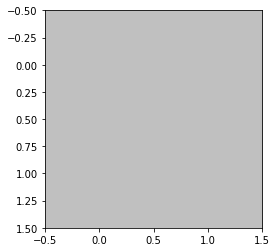

In [17]:
# Here are the CMAP bounds:
# -1 geq black < -0.1
# -0.1 geq gray < 0.001
# 0.001 geq red leq 1
a = 0.
arr1 = np.array([[a,a],[a,a]])
plt.imshow(arr1,cmap=CMAP,norm=NORM)
arr1

(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)


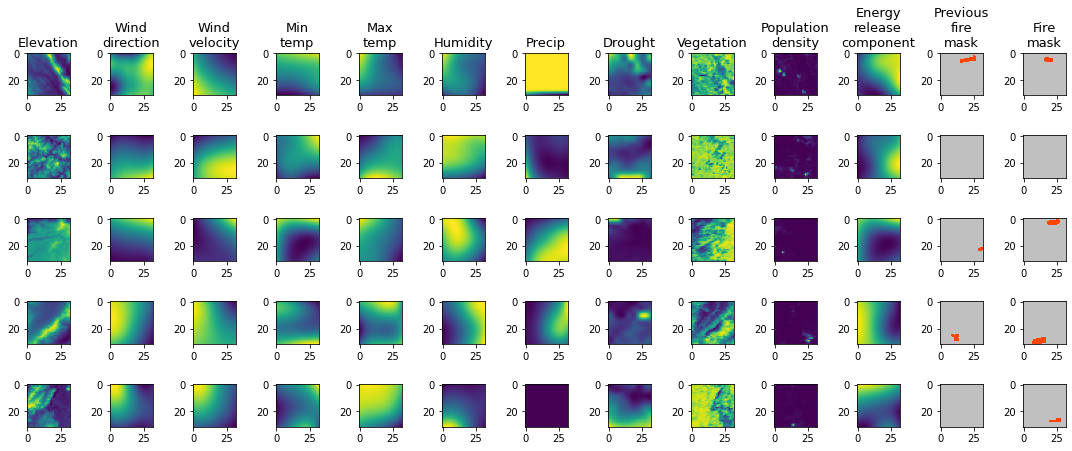

In [18]:
fig = plt.figure(figsize=(15,6.5))
n_rows1 = n_rows
n_rows = 5
for i in range(n_rows):
  for j in range(n_features + 1):
    plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
    if i == 0:
      plt.title(TITLES[j], fontsize=13)
    if j < n_features - 1:
      plt.imshow(inputs[i, :, :, j], cmap='viridis')
    if j == n_features - 1:
      plt.imshow(inputs[i, :, :, -1], cmap=CMAP, norm=NORM)
      print(inputs[i,:,:,-1].shape)
    if j == n_features:
      plt.imshow(labels[i, :, :, 0], cmap=CMAP, norm=NORM) 
    # plt.axis('off')
plt.tight_layout()

(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)


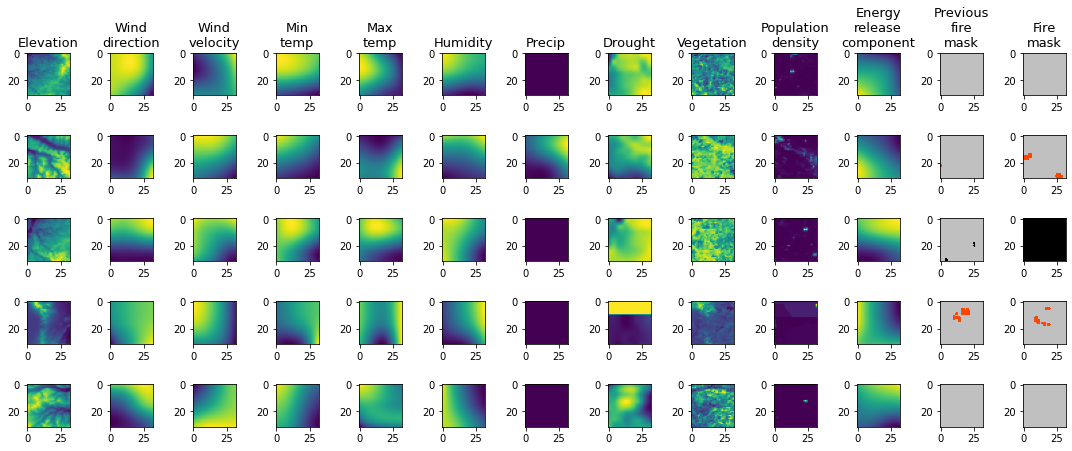

In [19]:
fig = plt.figure(figsize=(15,6.5))
n_rows1 = n_rows
n_rows = 5
for i in range(n_rows):
  for j in range(n_features + 1):
    plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
    if i == 0:
      plt.title(TITLES[j], fontsize=13)
    if j < n_features - 1:
      plt.imshow(x_test[i, :, :, j], cmap='viridis')
    if j == n_features - 1:
      plt.imshow(x_test[i, :, :, -1], cmap=CMAP, norm=NORM)
      print(x_test[i,:,:,-1].shape)
    if j == n_features:
      plt.imshow(y_test[i, :, :, 0], cmap=CMAP, norm=NORM) 
    # plt.axis('off')
plt.tight_layout()

#### Experimenting

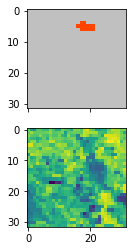

In [20]:
figure,ax = plt.subplots(nrows = 2, ncols=1,sharex=True)
ax[0].imshow(labels[0,:,:,0],cmap=CMAP,norm=NORM)
ax[1].imshow(inputs[0,:,:,8],cmap='viridis')



In [21]:
CMAP

## Custom Loss Functions

These are in progress, working on it right now.

In [22]:
arr1 = np.array([[1,2],[2,3],[3,4]])
a,b = arr1.shape
np.random.rand(a,b)

array([[0.54139107, 0.61082106],
       [0.18858907, 0.0535832 ],
       [0.07826251, 0.05500636]])

In [23]:
import numpy as np
def fakeLoss(y_true,y_pred):
  print(type(y_true))
  y_true = tf.make_ndarray(y_true)
  y_pred = tf.make_ndarray(y_pred)

  return np.sum((y_true+y_pred)**2)

def loss_mse(y_true,y_pred):
  return tf.reduce_sum(tf.square(y_true + y_pred))

# def confidence(array):
#   """
#   Parameters: 2D np array
#   Returns: processed 2D np array according to color map rules + difference from the bounds
#   """
#   a,b = array.shape
#   f_arr = np.random.rand(a,b)
#   for i in range(array.shape[0]):
#     for j in range(array.shape[1]):
#       bool1 = False
#       new_var = array[i,j]
#       if new_var <= 1 and new_var >= 0.001:
#         f_arr[i,j] = (new_var-1)**2 + (new_var-.001)**2
#       elif new_var < 0.001 and new_var >= -0.1:
#         f_arr[i,j] = (new_var-0.001)**2 + (new_var+0.1)**2
#       elif new_var <= -0.1 and new_var >= -1:
#         f_arr[i,j] = (new_var+1)**2 + (new_var+.1)**2
#   return f_arr
def convert(array):
  """
  Parameters: 2D tensor
  Returns: processed 2D np array according to color map rules + difference from the bounds
  0 - red
  1 - Gray
  2 - Black
  """
  array=tf.reshape(array,[32,32])
  a,b = array.shape
  f_arr = np.random.rand(32,32)
  for i in range(32):
    for j in range(32):
      new_var = array[i,j]
      if new_var >= 0.001:
        f_arr[i,j] = 0
      elif new_var < 0.001 and new_var >= -0.1:
        f_arr[i,j] = 1
      elif new_var <= -0.1:
        f_arr[i,j] = 2
  return f_arr 
def distance(y_true,a,b,c,d):
  """
  Parameters: (ytrue, numpy 2d array), (a, row index of ytrue right now), (b, column index), (c, )
  Output: distance between this point and nearest target value
  """
  return np.sqrt((c-a)**2 + (d-b)**2)
def gen_distance(y_true,y_pred):
  """
  Parameters: the converted 2D np array of ytrue and ypredicted
  Ouput: An array that has distance values from y_true to y_pred
  """
  assert y_true.shape == y_pred.shape

  a,b = y_true.shape
  f_arr = np.random.rand(a,b)
  for i in range(y_true.shape[0]):
    for j in range(y_true.shape[1]):
      maxDist=-1
      breakVar = False
      if y_true[i,j] != y_pred[i,j]:
        breakVar = False
        maxDist=-1
        for a in range(y_true.shape[0]):
          for b in range(y_true.shape[1]):
              if (distance(y_true,i,j,a,b)>maxDist):
                if (distance(y_true,i,j,a,b)>10):
                  maxDist=10
                  breakVar = True
                  break
                maxDist = distance(y_true,i,j,a,b)
          if (breakVar):
            break
      else:
        f_arr[i,j] = 0
  return f_arr

def punisher(y_true, y_pred):
  yTrue = convert(y_true)
  yPred = convert(y_pred)
  return np.sum(gen_distance(yTrue,yPred))

def mod_cross_entropy_loss(y_true,y_pred):
  true_sum = tf.reduce_sum(y_true)
  pred_sum = tf.reduce_sum(y_pred)
  yTrue = convert(y_true)/true_sum
  yPred = convert(y_pred)/pred_sum
  sum1 = 0
  sum1 = (y_true-y_pred)**2
  sum1 = tf.math.sqrt(tf.reduce_sum(sum1))
  sum1 = sum1.numpy()
  pred_prob = probDist(yPred.numpy())
  true_prob = probDist(yTrue.numpy())
  cross = -sum([true_prob[i]*math.log(pred_prob[i])/math.log(2) for i in range(len(true_prob))])
  return (sum1/1024) + probDist() 

# punisher(np.random.rand(32,32),np.random.rand(32,32))
# import numpy
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import keras
# import keras.backend as K
# # class DiceLoss(nn.Module):
# #     def __init__(self, weight=None, size_average=True):
# #         super(DiceLoss, self).__init__()

# #     def forward(self, inputs, targets, smooth=1):
        
# #         #comment out if your model contains a sigmoid or equivalent activation layer
# #         inputs = F.sigmoid(inputs)       
        
# #         #flatten label and prediction tensors
# #         inputs = inputs.view(-1)
# #         targets = targets.view(-1)
        
# #         intersection = (inputs * targets).sum()                            
# #         dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
# #         return 1 - dice
def spec_dice_loss(y_true, y_pred):
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.math.sigmoid(y_pred)
  numerator = 2 * tf.reduce_sum(y_true * y_pred)
  denominator = tf.reduce_sum(y_true + y_pred)

  return 1 - numerator / denominator

# from scipy.spatial import distance_matrix
# import numpy as np

# not_zeros = np.argwhere(img != 0)
# zeros = np.argwhere(img == 0)

# dist_matrix = distance_matrix(zeros, not_zeros, p=2)
# output = np.zeros((HEIGHT, WIDTH, 1), dtype=np.uint8)

# i = 0
# dist = np.min(dist_matrix, axis=1)
# for y in range(HEIGHT):
#   for x in range(WIDTH):
#     if img[y,x] == 0:
#       output[y,x] = dist[i]
#       i += 1

# from functools import partial

# def loss_function(y_true, y_pred, weights):
# ...

# weight_input = Input(shape=(HEIGHT, WIDTH))
# loss = partial(loss_function, weights=weight_input)



### Classic Loss Functions

In [24]:
from keras import backend as K
import math
# Focal Tversky_loss
def probDist(y):
  classes = [0,1,2]
  prob = [0,0,0]
  for i in range(y.shape[0]):
    for j in range(y.shape[1]):
      if (y[i,j] == 0):
        prob[0]+=1
      if (y[i,j] == 1):
        prob[1]+=1
      if (y[i,j] == 2):
        prob[2]+=1
  prob = np.array(prob)
  return prob/(np.sum(prob))
def weighted_bce(y_true, y_pred):
  weights = (y_true * 59.) + 1.
  bce = K.binary_crossentropy(y_true, y_pred)
  weighted_bce = K.mean(bce * weights)
  return weighted_bce
def class_tversky(y_true, y_pred):
    smooth = 1

    y_true = K.permute_dimensions(y_true, (3,1,2,0))
    y_pred = K.permute_dimensions(y_pred, (3,1,2,0))

    y_true_pos = K.batch_flatten(y_true)
    y_pred_pos = K.batch_flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos, 1)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos), 1)
    false_pos = K.sum((1-y_true_pos)*y_pred_pos, 1)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def focal_tversky_loss(y_true,y_pred):
    pt_1 = class_tversky(y_true, y_pred)
    gamma = 0.75
    return K.sum(K.pow((1-pt_1), gamma))

# Dice Loss
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

#Keras
ALPHA = 0.8
GAMMA = 2

def focal_loss(targets, inputs, alpha=ALPHA, gamma=GAMMA):    
    
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    BCE = K.binary_crossentropy(targets, inputs)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(alpha * K.pow((1-BCE_EXP), gamma) * BCE)
    
    return focal_loss

def dice_coef_binary(y_true, y_pred, smooth=1e-7):
    '''
    Dice coefficient for 2 categories. Ignores background pixel label 0
    Pass to model as metric during compile statement
    '''
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=2)[...,1:])
    y_pred_f = K.flatten(y_pred[...,1:])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersect / (denom + smooth)))


def dice_coef_binary_loss(y_true, y_pred):
    '''
    Dice loss to minimize. Pass to model as loss during compile statement
    '''
    return 1 - dice_coef_binary(y_true, y_pred)

def get_loss_function(loss_function_name):
    if loss_function_name == "focal_tversky_loss":
        loss_function = focal_tversky_loss
    elif loss_function_name == "dice_coef_loss":
        loss_function = dice_coef_loss
    elif loss_function_name == "dice_coef_binary_loss":
        loss_function = dice_coef_binary_loss
    elif loss_function_name == "focal_loss":
        loss_function = focal_loss
    elif loss_function_name == "sparse_categorical_crossentropy":
        loss_function = tf.keras.losses.SparseCategoricalCrossentropy()
    else:
        loss_function = loss_function_name # for keras implemented losses like "categorical_crossentropy"
        
    return loss_function

## Models

### Keras CNN 

In [25]:
from tensorflow.keras import Input
DROPOUT = 0.7

input_arr = [] #size 12
models_arr = [] #size 12
for i in range(12):
  input_arr.append(Input(shape=(32,32,1)))
for i in range(12):
  models_arr.append(layers.Conv2D(64,(3,3),activation='relu',padding='same')(input_arr[i]))
  models_arr[i] = layers.MaxPool2D((2,2))(models_arr[i])
  models_arr[i] = layers.BatchNormalization()(models_arr[i])
  models_arr[i] = layers.Dropout(DROPOUT)(models_arr[i])


  models_arr[i]=layers.Conv2D(16,(3,3),activation='relu',padding='same')(models_arr[i])
  models_arr[i] = layers.MaxPool2D((2,2))(models_arr[i])
  models_arr[i] = layers.BatchNormalization()(models_arr[i])
  models_arr[i] = layers.Dropout(DROPOUT)(models_arr[i])
# input_arr = np.array(input_arr)
  
encoder = layers.concatenate(models_arr)
encoder_model = Model(input_arr,encoder)
encoder_model.summary()
# models_arr[0].summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 input_15 (InputLayer)          [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 input_16 (InputLayer)          [(None, 32, 32, 1)]  0           []                               
                                                                                              

In [37]:
autoencoder = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoder)
autoencoder = (layers.UpSampling2D((2, 2)))(autoencoder)
autoencoder = layers.BatchNormalization()(autoencoder)
autoencoder = layers.Dropout(DROPOUT)(autoencoder)


autoencoder = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(autoencoder)
autoencoder = tf.keras.layers.UpSampling2D((2, 2)) (autoencoder)
autoencoder = layers.BatchNormalization()(autoencoder)
autoencoder = layers.Dropout(DROPOUT)(autoencoder)


autoencoder = layers.Conv2D(1, (3, 3), activation='tanh', padding='same')(autoencoder)
autoencoder = Model(inputs = input_arr,outputs = autoencoder)
autoencoder.compile(optimizer='adam', loss='mse',metrics=['accuracy'],run_eagerly=True)

# autoencoder.summary()

#### Training

In [28]:

# autoencoder.fit({inputs[:,:,:,0:1]},labels)

# autoencoder.fit({inputs[:,:,:,0:1]},labels).
def dataProcess(data):
  k = []
  for i in range(12):
    k.append(data[:,:,:,i:i+1])
  return k


k = dataProcess(inputs)
mod_x_test = dataProcess(x_test)
history_1 = autoencoder.fit(
            k, labels,
            epochs=300,
            validation_data = (mod_x_test,y_test),
            batch_size=12,
            verbose=2)

# l = []
# validation_data=(np.random.randn(12,100,32,32,1).tolist(),np.random.randn(100,32,32,1).tolist()),

# for i in range(12):
#   l.append(inputs[0,:,:,i])
# l
# # autoencoder.evaluate(l)
# # plt.imshow(autoencoder.predict(k[0]))

Epoch 1/300
9/9 - 13s - loss: 0.6833 - accuracy: 0.5837 - val_loss: 0.7834 - val_accuracy: 0.7341 - 13s/epoch - 1s/step
Epoch 2/300
9/9 - 1s - loss: 0.6009 - accuracy: 0.6224 - val_loss: 1.0304 - val_accuracy: 0.0424 - 1s/epoch - 140ms/step
Epoch 3/300
9/9 - 1s - loss: 0.4990 - accuracy: 0.6550 - val_loss: 0.9336 - val_accuracy: 0.0932 - 1s/epoch - 141ms/step
Epoch 4/300
9/9 - 1s - loss: 0.3575 - accuracy: 0.7419 - val_loss: 0.9329 - val_accuracy: 0.0648 - 1s/epoch - 141ms/step
Epoch 5/300
9/9 - 1s - loss: 0.2443 - accuracy: 0.8225 - val_loss: 0.5792 - val_accuracy: 0.2511 - 1s/epoch - 141ms/step
Epoch 6/300
9/9 - 1s - loss: 0.1876 - accuracy: 0.8809 - val_loss: 0.3780 - val_accuracy: 0.4597 - 1s/epoch - 140ms/step
Epoch 7/300
9/9 - 1s - loss: 0.1766 - accuracy: 0.8968 - val_loss: 0.2131 - val_accuracy: 0.9004 - 1s/epoch - 140ms/step
Epoch 8/300
9/9 - 1s - loss: 0.1352 - accuracy: 0.9164 - val_loss: 0.1648 - val_accuracy: 0.9423 - 1s/epoch - 140ms/step
Epoch 9/300
9/9 - 1s - loss: 0.10

## Evaluation Visualizations

In [29]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
a,b = 18,0

### Train Predictions

In [30]:
var1 = autoencoder.predict(k)

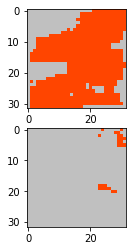

In [31]:
fig1, ax1 = plt.subplots(2,1)
a = 5
ax1[0].imshow(var1[a,:,:,0],cmap=CMAP,norm=NORM)
ax1[1].imshow(labels[a,:,:,0],cmap=CMAP,norm=NORM)


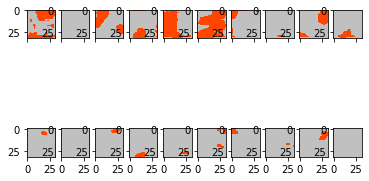

<Figure size 3200x3200 with 0 Axes>

In [32]:
fig_tr,ax_tr = plt.subplots(nrows = 2, ncols=10,sharex=True)
figure(figsize=(40, 40), dpi=80)
for i in range(10):
  ax_tr[0][i].imshow(var1[i,:,:,b],cmap=CMAP,norm=NORM)
  ax_tr[1][i].imshow(labels[i,:,:,b],cmap=CMAP,norm=NORM)

In [34]:
accuracy = autoencoder.evaluate(mod_x_test, y_test, verbose=2)


4/4 - 0s - loss: 0.0468 - accuracy: 0.9446 - 196ms/epoch - 49ms/step


In [ ]:
# Here we would get the output as probablities for each category
y_pred=model.predict(mod_x_test)

In [38]:
# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module

confusion_matrix = tf.math.confusion_matrix(mod_x_test,y_test)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()


InvalidArgumentError: ignored

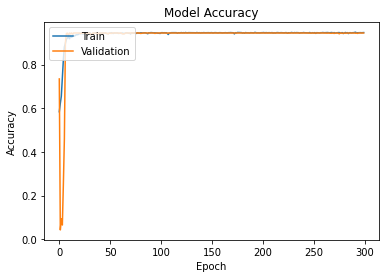

In [35]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


### Test Predictions

In [ ]:
test_123 = dataProcess(x_test)
var2 = autoencoder.predict(test_123)
autoencoder.evaluate(test_123,y_test,verbose=2)

In [ ]:
fig,ax = plt.subplots(nrows = 2, ncols=10,sharex=True)
figure(figsize=(40, 40), dpi=80)
for i in range(10):
  ax[0][i].imshow(var2[i,:,:,b],cmap=CMAP,norm=NORM)
  ax[1][i].imshow(y_test[i,:,:,b],cmap=CMAP,norm=NORM)

plt.tight_layout()

max = 0
for i in np.abs(var1):
  if(max<np.amax(i)):
    max = np.amax(i)
print("MAX:", max)
var1.shape

In [ ]:
plt.imshow(labels[0,:,:,0])
# labels[0,:,:,0]

### Model Saving

In [ ]:
import pickle
def pickleDump(model,name):
  with open(name,'wb') as f:
    pickle.dump(model,f)
def pickleLoad(name):
  with open(name,'rb') as f:
    m = pickle.load(f)
  return m

pickleDump(autoencoder,"autoencoder")